In [1]:
import pandas as pd
import glob
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import arcadia_pycolor as apc


In [2]:
apc.mpl.setup()

In [3]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)marker', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))

                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value

            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [4]:
linear_df = harvest_mod_outputs('./linear_model', 'qhaplo_*qtl_*marker_*n_rep*_scklrr_corr_summary.txt')
linear_fs_df = harvest_mod_outputs('./gphybrid', 'qhaplo_*qtl_*marker_*n_rep*_linear_pruned_correlations.csv')

neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*marker_*n_rep*_phenotype_correlations.csv')
neural_fs_df = harvest_mod_outputs('./gphybrid', 'qhaplo_*qtl_*marker_*n_rep*_mlp_pruned_correlations.csv')

   trait  pearson_corr_pheno_mean  pearson_corr_pheno_std  \
0      1                 0.999947                0.000002   
1      2                 0.510425                0.020918   
2      1                 0.999948                0.000002   
3      2                 0.565902                0.020928   
4      1                 0.999944                0.000003   

   pearson_corr_beta_mean  pearson_corr_beta_std  best_lambda_mean  \
0                0.999998           8.699933e-08          0.006734   
1                0.966199           1.645841e-03        148.496826   
2                0.999999           4.914627e-08          0.002656   
3                0.987324           8.792221e-04         52.493048   
4                0.999993           1.370536e-07          0.027186   

   best_lambda_std  qtl_param  n_param  rep  
0     9.142795e-19        250    10000    3  
1     0.000000e+00        250    10000    3  
2     4.571398e-19        100    10000    3  
3     6.405889e+00        10

In [5]:
linear_df.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
linear_df.rename(columns={'trait':'trait_number'}, inplace=True)


In [6]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'rep'])

    return common_params

In [7]:
common_params = get_parameter_combinations(linear_df, neural_df)
common_params2 = get_parameter_combinations(linear_df, linear_fs_df)
common_params3 = get_parameter_combinations(linear_df, neural_fs_df)

In [8]:
def generate_comparison_df(df1, df2, common_params):
    """
    Generates paired comparison dataframe from two input dataframes that contain prediciton results from different models

    Args: The two dataframes to compare, and common param combinations
    Returns: Single dataframe with paired up outputs
    """
    comparison_data = []

    for _, row in common_params.iterrows():
        qtl = row['qtl_param']
        n = row['n_param']
        trait = row['trait_number']
        rep = row['rep']

        linear_row = df1[(df1['qtl_param'] == qtl) &
                            (df1['n_param'] == n) &
                            (df1['trait_number'] == trait) &
                            (df1['rep'] == rep)]

        neural_row = df2[(df2['qtl_param'] == qtl) &
                            (df2['n_param'] == n) &
                            (df2['trait_number'] == trait)&
                            (df2['rep'] == rep)]

        if not linear_row.empty and not neural_row.empty:
            comparison_data.append({
                'qtl_param': qtl,
                'n_param': n,
                'trait_number': trait,
                'rep': rep,
                'df1_correlation': linear_row['pearson_correlation'].values[0],
                'df2_correlation': neural_row['pearson_correlation'].values[0],
                'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


In [9]:
comparison_df = generate_comparison_df(linear_df, neural_df, common_params)
comparison_df2 = generate_comparison_df(linear_df, linear_fs_df, common_params2)
comparison_df3 = generate_comparison_df(linear_df, neural_fs_df, common_params3)

In [10]:

def generate_multi_comparison_plot(comparison_dfs, df_names=None, xname="Linear", yname="Neural"):
    """
    Generate comparison plots for multiple dataframes, coloring points by their origin dataframe.

    Parameters:
    -----------
    comparison_dfs : list of pandas.DataFrame
        List of dataframes to compare. Each dataframe should have columns:
        'qtl_param', 'trait_number', 'df1_correlation', 'df2_correlation'

    df_names : list of str, optional
        Names for each dataframe for the legend. If None, defaults to "Dataset 1", "Dataset 2", etc.

    xname : str, default="Linear"
        Label for x-axis (df1_correlation)

    yname : str, default="Neural"
        Label for y-axis (df2_correlation)

    Returns:
    --------
    fig, axes : matplotlib Figure and Axes objects
    """
    # Assign default dataframe names if not provided
    if df_names is None:
        df_names = [f"Dataset {i+1}" for i in range(len(comparison_dfs))]

    # Ensure we have the same number of names as dataframes
    assert len(df_names) == len(comparison_dfs), "Number of dataframe names must match number of dataframes"

    # Create a combined dataframe with a 'source' column to track origin
    combined_df = pd.DataFrame()
    for i, df in enumerate(comparison_dfs):
        temp_df = df.copy()
        temp_df['source'] = df_names[i]
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    # Get unique qtl_param values and sort them
    unique_qtl_params = sorted(combined_df['qtl_param'].unique())

    # Calculate rows and columns for subplots
    n_plots = len(unique_qtl_params)
    n_cols = int(np.ceil(n_plots / 2))  # Divide plots evenly between two rows
    n_rows = 2 if n_plots > 1 else 1    # Use 2 rows unless there's only 1 plot

    # Create a figure with subplots arranged in two rows
    fig, axes = plt.subplots(n_rows, n_cols,
                           figsize=(2.5*n_cols, 2.5*n_rows),
                           sharey=True, sharex=True)

    # Convert axes to a 1D array for easier indexing
    axes = np.array(axes).flatten() if n_plots > 1 else np.array([axes])

    # Create a colormap for different dataframes
    # Use a qualitative colormap for discrete datasets
    #colors = plt.cm.viridis(np.linspace(0, 1, len(df_names)))


    cmap = apc.gradients.viridis.to_mpl_cmap()
    colors = cmap(np.linspace(0, 1, len(df_names)))

    color_dict = {name: color for name, color in zip(df_names, colors)}

    # Create a colormap for trait_number (for marker size variation)
    trait_norm = plt.Normalize(vmin=combined_df['trait_number'].min(),
                              vmax=combined_df['trait_number'].max())

    # Process each qtl_param in a separate subplot
    for i, qtl_val in enumerate(unique_qtl_params):
        if i < len(axes):  # Safety check
            ax = axes[i]

            # Filter data for this qtl_param
            subset = combined_df[combined_df['qtl_param'] == qtl_val]

            # Create scatter plots for each dataset with different colors
            for df_name in df_names:
                df_subset = subset[subset['source'] == df_name]
                if not df_subset.empty:
                    # Size based on trait_number
                    sizes = 30 + 40 * trait_norm(df_subset['trait_number'])

                    ax.scatter(df_subset['df1_correlation'], df_subset['df2_correlation'],
                             color=color_dict[df_name],
                             s=sizes,
                             alpha=0.8,
                             edgecolor='black',
                             linewidth=0.5,
                             label=df_name)

            # Add 1:1 line
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.7)

            # Set equal aspect to make the 1:1 line truly diagonal
            ax.set_aspect('equal')

            # Add labels and title for this subplot
            ax.set_title(f'QTL# =  {qtl_val}', fontsize=12)

            # Add axis labels (only for left-edge and bottom-edge subplots)
            if i % n_cols == 0:  # Left edge of grid
                ax.set_ylabel(f'{yname} Pearsons r', fontsize=11)
            if i >= n_plots - n_cols:  # Bottom edge of grid
                ax.set_xlabel(f'{xname} Pearsons r', fontsize=11)

    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)

    # Create legend for datasets
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[name],
                            markersize=8, label=name) for name in df_names]

    # Add the legend outside the plots
    fig.legend(handles=legend_elements, loc='upper center',
              bbox_to_anchor=(0.5, 0.01), ncol=len(df_names))

    # Adjust layout
    #plt.tight_layout()
    plt.subplots_adjust(right=0.9, bottom=0.15, top=0.9)  # Make room for legend, colorbar and title

    return fig, axes

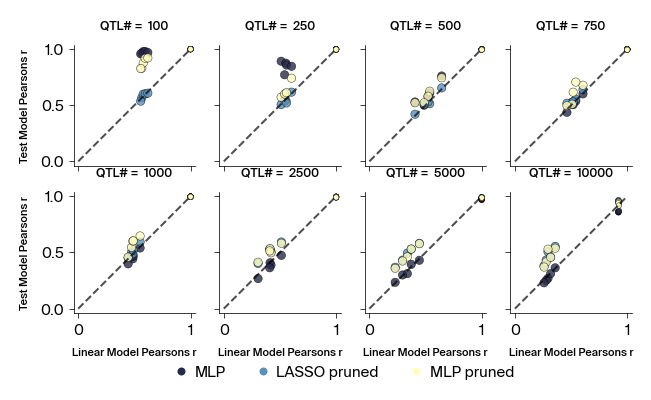

In [11]:
fig, axes = generate_multi_comparison_plot(
    [comparison_df, comparison_df2, comparison_df3],
    df_names=["MLP", "LASSO pruned", "MLP pruned"],
    xname="Linear Model",
    yname="Test Model"
)

In [12]:
def generate_multi_comparison_plot(comparison_dfs, df_names=None, xname="Linear", yname="Neural"):
    """
    Generate comparison plots for multiple dataframes, coloring points by their origin dataframe
    and varying marker shapes based on trait_number.

    Parameters:
    -----------
    comparison_dfs : list of pandas.DataFrame
        List of dataframes to compare. Each dataframe should have columns:
        'qtl_param', 'trait_number', 'df1_correlation', 'df2_correlation'

    df_names : list of str, optional
        Names for each dataframe for the legend. If None, defaults to "Dataset 1", "Dataset 2", etc.

    xname : str, default="Linear"
        Label for x-axis (df1_correlation)

    yname : str, default="Neural"
        Label for y-axis (df2_correlation)

    Returns:
    --------
    fig, axes : matplotlib Figure and Axes objects
    """
    # Assign default dataframe names if not provided
    if df_names is None:
        df_names = [f"Dataset {i+1}" for i in range(len(comparison_dfs))]

    # Ensure we have the same number of names as dataframes
    assert len(df_names) == len(comparison_dfs), "Number of dataframe names must match number of dataframes"

    # Create a combined dataframe with a 'source' column to track origin
    combined_df = pd.DataFrame()
    for i, df in enumerate(comparison_dfs):
        temp_df = df.copy()
        temp_df['source'] = df_names[i]
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    # Get unique qtl_param values and sort them
    unique_qtl_params = sorted(combined_df['qtl_param'].unique())

    # Get unique trait_number values and sort them
    unique_traits = sorted(combined_df['trait_number'].unique())

    # Calculate rows and columns for subplots
    n_plots = len(unique_qtl_params)
    n_cols = int(np.ceil(n_plots / 2))  # Divide plots evenly between two rows
    n_rows = 2 if n_plots > 1 else 1    # Use 2 rows unless there's only 1 plot

    # Create a figure with subplots arranged in two rows
    fig, axes = plt.subplots(n_rows, n_cols,
                           figsize=(3.5*n_cols, 3.5*n_rows),
                           sharey=True, sharex=True)

    # Convert axes to a 1D array for easier indexing
    axes = np.array(axes).flatten() if n_plots > 1 else np.array([axes])

    # Create a colormap for different dataframes
    cmap = apc.gradients.viridis.to_mpl_cmap()
    colors = cmap(np.linspace(0, 1, len(df_names)))
    color_dict = {name: color for name, color in zip(df_names, colors)}

    # Define marker shapes for different trait numbers
    # Using common marker styles in matplotlib
    markers = ['D', 'o']

    # Ensure we have enough markers for all traits
    while len(markers) < len(unique_traits):
        markers.extend(markers)
    markers = markers[:len(unique_traits)]

    marker_dict = {trait: marker for trait, marker in zip(unique_traits, markers)}

    # Create a mapping from trait number to display label
    # Using LaTeX format for proper subscripts on both a and g
    trait_labels = {}
    for trait in unique_traits:
        if trait == 1:
            trait_labels[trait] = r'$V_{A}/V_{G} = 1$'
        elif trait == 2:  # Changed from trait == 5 to trait == 2
            trait_labels[trait] = r'$V_{A}/V_{G} = 0.3$'
        else:
            trait_labels[trait] = f'Trait {trait}'

    # Process each qtl_param in a separate subplot
    for i, qtl_val in enumerate(unique_qtl_params):
        if i < len(axes):  # Safety check
            ax = axes[i]

            # Filter data for this qtl_param
            subset = combined_df[combined_df['qtl_param'] == qtl_val]

            # Create scatter plots for each dataset with different colors
            for df_name in df_names:
                df_subset = subset[subset['source'] == df_name]
                if not df_subset.empty:
                    # Plot each trait_number with its own marker
                    for trait in unique_traits:
                        trait_subset = df_subset[df_subset['trait_number'] == trait]
                        if not trait_subset.empty:
                            ax.scatter(trait_subset['df1_correlation'], trait_subset['df2_correlation'],
                                     color=color_dict[df_name],
                                     marker=marker_dict[trait],
                                     s=80,  # Fixed size now that we vary by shape
                                     alpha=0.9,
                                     edgecolor='black',
                                     linewidth=0.5,
                                     label=f"{df_name}, {trait_labels[trait]}" if i == 0 else "_nolegend_")

            # Add 1:1 line
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.7)

            # Set equal aspect to make the 1:1 line truly diagonal
            ax.set_aspect('equal')

            # Add labels and title for this subplot
            ax.set_title(f'QTL# = {qtl_val}', fontsize=12)

            # Add axis labels (only for left-edge and bottom-edge subplots)
            if i % n_cols == 0:  # Left edge of grid
                ax.set_ylabel(f'{yname} Pearsons r', fontsize=11)
            if i >= n_plots - n_cols:  # Bottom edge of grid
                ax.set_xlabel(f'{xname} Pearsons r', fontsize=11)

    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)

    # Create two separate legends
    # 1. Legend for datasets (colors)
    color_legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[name],
                                  markersize=8, label=name) for name in df_names]

    # 2. Legend for trait numbers (shapes) with the custom labels
    shape_legend_elements = [Line2D([0], [0], marker=marker_dict[trait], color='gray',
                                   markersize=8, label=trait_labels[trait]) for trait in unique_traits]

    # Add the legends in a single row at the bottom
    # Place color legend on the left and shape legend on the right
    fig.legend(handles=color_legend_elements, loc='lower left',
              bbox_to_anchor=(0.15, 0.01), ncol=min(len(df_names), 3))

    # Changed title to "Va/Vg Ratio" to better reflect the content
    fig.legend(handles=shape_legend_elements, loc='lower right',
              bbox_to_anchor=(0.85, 0.01), ncol=min(len(unique_traits), 4))

    # Adjust layout for two legends
    plt.subplots_adjust(right=0.95, left=0.1, bottom=0.2, top=0.9)  # Make more room at the bottom for both legends

    return fig, axes

## Figure 2.

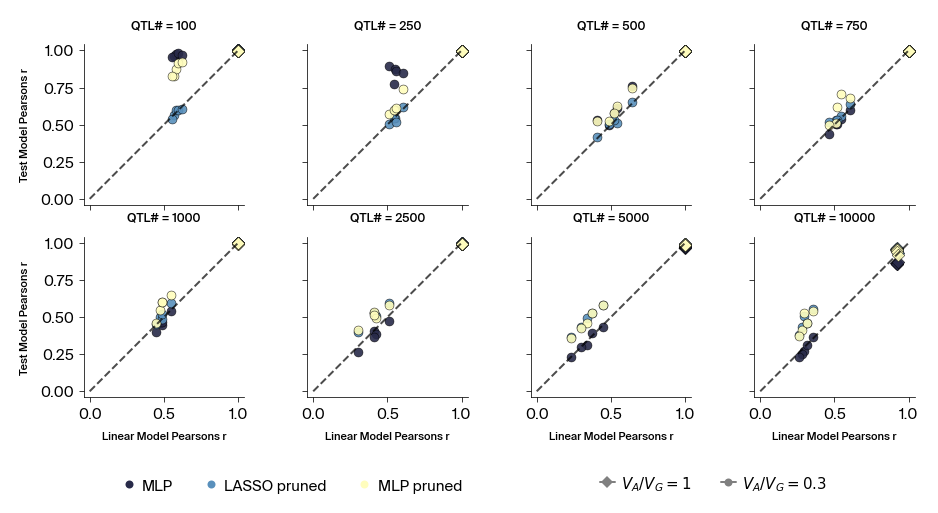

In [13]:
fig, axes = generate_multi_comparison_plot(
    [comparison_df, comparison_df2, comparison_df3],
    df_names=["MLP", "LASSO pruned", "MLP pruned"],
    xname="Linear Model",
    yname="Test Model"
)

#plt.savefig("Figure_2_lropt.svg", bbox_inches='tight')


In [24]:
def generate_multi_comparison_plot(comparison_dfs, df_names=None, xname="Linear", yname="Neural"):
    """
    Generate comparison plots for multiple dataframes, showing histograms of the difference
    in correlation (df2_correlation - df1_correlation) against the linear model benchmark.

    Parameters:
-----------
comparison_dfs : list of pandas.DataFrame
    List of dataframes to compare. Each dataframe should have columns:
    'qtl_param', 'trait_number', 'df1_correlation', 'df2_correlation'

df_names : list of str, optional
    Names for each dataframe for the legend. If None, defaults to "Dataset 1", "Dataset 2", etc.

xname : str, default="Linear"
    Label for x-axis reference model (df1_correlation)

yname : str, default="Neural"
    Label for y-axis model (df2_correlation)

Returns:
--------
fig, axes : matplotlib Figure and Axes objects
"""
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D

    # Assign default dataframe names if not provided
    if df_names is None:
        df_names = [f"Dataset {i+1}" for i in range(len(comparison_dfs))]

    # Ensure we have the same number of names as dataframes
    assert len(df_names) == len(comparison_dfs), "Number of dataframe names must match number of dataframes"

    # Create a combined dataframe with a 'source' column to track origin
    combined_df = pd.DataFrame()
    for i, df in enumerate(comparison_dfs):
        temp_df = df.copy()
        temp_df['source'] = df_names[i]
        # Calculate difference between models (Neural - Linear)
        temp_df['correlation_diff'] = temp_df['df2_correlation'] - temp_df['df1_correlation']
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    # Get unique qtl_param values and sort them
    unique_qtl_params = sorted(combined_df['qtl_param'].unique())

    # Get unique trait_number values and sort them
    unique_traits = sorted(combined_df['trait_number'].unique())

    # Calculate rows and columns for subplots
    n_plots = len(unique_qtl_params)
    n_cols = int(np.ceil(n_plots / 2))  # Divide plots evenly between two rows
    n_rows = 2 if n_plots > 1 else 1    # Use 2 rows unless there's only 1 plot

    # Create a figure with subplots arranged in two rows
    fig, axes = plt.subplots(n_rows, n_cols,
                        figsize=(3.5*n_cols, 3.5*n_rows),
                        sharey=True, sharex=True)

    # Convert axes to a 1D array for easier indexing
    axes = np.array(axes).flatten() if n_plots > 1 else np.array([axes])

    # Create a colormap for different dataframes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(df_names)))
    color_dict = {name: color for name, color in zip(df_names, colors)}

    # Create a mapping from trait number to display label
    trait_labels = {}
    for trait in unique_traits:
        if trait == 1:
            trait_labels[trait] = r'$V_{A}/V_{G} = 1$'
        elif trait == 2:
            trait_labels[trait] = r'$V_{A}/V_{G} = 0.3$'
        else:
            trait_labels[trait] = f'Trait {trait}'

    # Process each qtl_param in a separate subplot
    for i, qtl_val in enumerate(unique_qtl_params):
        if i < len(axes):  # Safety check
            ax = axes[i]

            # Filter data for this qtl_param
            subset = combined_df[combined_df['qtl_param'] == qtl_val]

            # Prepare data for boxplots
            boxplot_data = []
            boxplot_positions = []
            boxplot_colors = []
            boxplot_labels = []

            # Set up positions for the two trait groups
            trait_positions = {
                1: [1, 2, 3],  # First 3 positions for trait 1 (additive)
                2: [5, 6, 7]   # Next 3 positions for trait 2 (epistatic)
            }

            # For each trait and dataset, create a boxplot
            for trait in unique_traits:
                for df_idx, df_name in enumerate(df_names):
                    # Get the position for this dataset within its trait group
                    position = trait_positions[trait][df_idx]

                    # Filter data for this dataset and trait
                    filtered_data = subset[(subset['source'] == df_name) &
                                        (subset['trait_number'] == trait)]

                    if not filtered_data.empty:
                        boxplot_data.append(filtered_data['correlation_diff'].values)
                        boxplot_positions.append(position)
                        boxplot_colors.append(color_dict[df_name])

                        # Create label only for the first qtl_param subplot
                        label = f"{df_name}" if i == 0 else "_nolegend_"
                        boxplot_labels.append(label)

            # Create boxplots
            bp = ax.boxplot(boxplot_data, positions=boxplot_positions, patch_artist=True,
                        widths=0.6, showfliers=True)

            # Customize boxplot colors
            for box, color, label in zip(bp['boxes'], boxplot_colors, boxplot_labels):
                box.set(facecolor=color, alpha=0.6, linewidth=1.5)
                # Add to legend only if it's a real label (not "_nolegend_")
                if label != "_nolegend_":
                    box.set(label=label)

            # Customize other boxplot elements
            for element in ['whiskers', 'caps', 'medians']:
                for item in bp[element]:
                    item.set(color='black', linewidth=1.5)

            for flier in bp['fliers']:
                flier.set(marker='o', markerfacecolor='none', markeredgecolor='black',
                        markersize=4, alpha=0.7)

            # Add horizontal line at y=0 (no difference between models)
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.7)

            # Add labels and title for this subplot
            ax.set_title(f'QTL# = {qtl_val}', fontsize=12)

            # Add group labels above each set of boxplots
            for trait in unique_traits:
                # Calculate the center position for the label
                center_pos = sum(trait_positions[trait]) / len(trait_positions[trait])

                # Add the label above the boxplots
                ax.text(center_pos, ax.get_ylim()[1] * 0.9,
                    trait_labels[trait],
                    ha='center', va='center',
                    fontsize=10, fontweight='bold')

            # Add vertical line to separate the two trait groups
            ax.axvline(x=4, color='gray', linestyle='-', alpha=0.3, linewidth=1)

            # Set x-ticks to match our boxplot groups but don't show tick labels
            ax.set_xticks([2, 6])  # Center of each group
            ax.set_xticklabels([])  # No labels on x-axis

            # Add axis labels (only for left-edge and bottom-edge subplots)
            if i % n_cols == 0:  # Left edge of grid
                ax.set_ylabel(f'{yname} - {xname}\n(Pearsons r difference)', fontsize=11)

            # Set consistent y-axis limits based on data range
            y_min = min(combined_df['correlation_diff'].min() - 0.05, -0.05)
            y_max = max(combined_df['correlation_diff'].max() + 0.05, 0.05)
            ax.set_ylim(y_min, y_max)

            # Set consistent x-axis limits to leave space for the group labels
            ax.set_xlim(0, 8)

    # Hide any unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)

    # Create legend for datasets (colors)
    color_legend_elements = [mpatches.Patch(color=color_dict[name], alpha=0.6,
                                        label=name) for name in df_names]

    # Add the legend at the bottom
    fig.legend(handles=color_legend_elements, loc='lower center',
            bbox_to_anchor=(0.5, 0.01), ncol=min(len(df_names), 3))

    # Adjust layout for the legend
    plt.subplots_adjust(right=0.95, left=0.1, bottom=0.15, top=0.9)

    return fig, axes

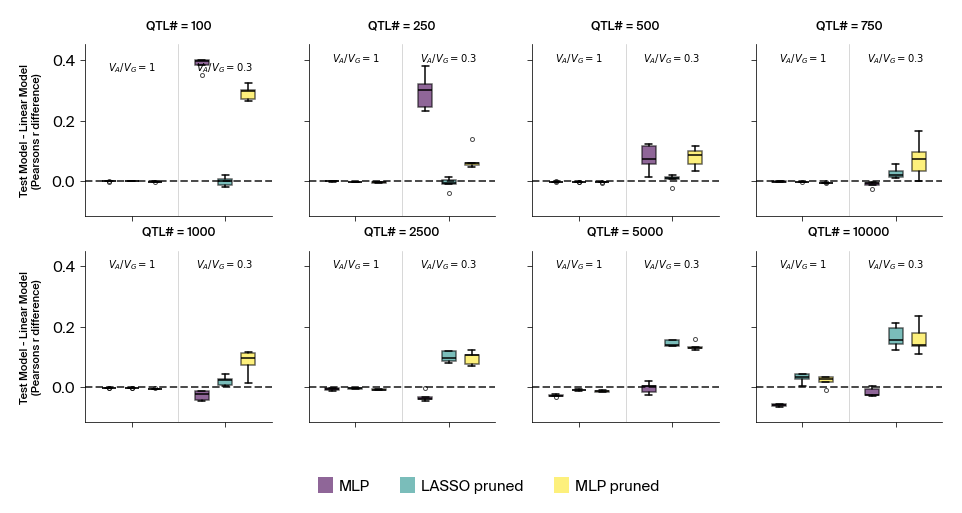

In [25]:
fig, axes = generate_multi_comparison_plot(
    [comparison_df, comparison_df2, comparison_df3],
    df_names=["MLP", "LASSO pruned", "MLP pruned"],
    xname="Linear Model",
    yname="Test Model"
)